# Bayesian Model Mixing
### Evan Edwards

- Multivariate Mixing With The Following Models That Use Mixed-Informative Priors:
    - PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID)
    - PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID)
    - PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID)
    - PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID)

In [1]:
from Taweret.core.base_model import BaseModel
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pandas as pd
from sklearn.metrics import mean_squared_error
from Taweret.mix.gaussian import Multivariate
from math import sqrt
from scipy.optimize import minimize
import arviz as az
import logging

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# Fixed random seed to ensure reproducibility and the possiblility for optimization
RANDOM_SEED = 9572404
rng = np.random.default_rng(RANDOM_SEED)


In [4]:
# Defining to disable output later for ease of visibility
logger = logging.getLogger("pymc")
# Disabling sampling messages
logger.setLevel(logging.ERROR)

In [5]:
# Load dataset
PISA2018 = pd.read_csv("pisa2018.BayesBook.csv")
# Data processing: converting categorical values to numerical values
PISA2018['Female'] = PISA2018['Female'].replace({'Female': 1.0, 'Male': 0.0})
# Converting numerical to categorical values
PISA2018['SchoolID'] = pd.Categorical(PISA2018['SchoolID']).codes

PISA2018 = PISA2018[["PV1READ","Female","ESCS", "HOMEPOS", "ICTRES", "JOYREAD", "WORKMAST","PISADIFF","TEACHINT","BELONG","SCREADCOMP","SCREADDIFF","METASUM","GFOFAIL","MASTGOAL","SWBP","ADAPTIVITY","SchoolID","COMPETE","PERFEED"]]

In [6]:
%%time
#PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID)

with pm.Model() as model1:
    Female = pm.MutableData("Female",PISA2018["Female"])
    ESCS = pm.MutableData("ESCS", PISA2018["ESCS"])
    HOMEPOS = pm.MutableData("HOMEPOS", PISA2018["HOMEPOS"])
    ICTRES = pm.MutableData("ICTRES", PISA2018["ICTRES"])
    SchoolID = pm.MutableData("SchoolID", PISA2018["SchoolID"])

    alpha = pm.Normal('alpha', mu=0, sigma=100)  # Intercept
    beta_female = pm.Normal('beta_female', mu=0, sigma=10)  # Coefficient for Female
    beta_escs = pm.Normal('beta_escs', mu=np.mean(PISA2018["ESCS"]), sigma = np.std(PISA2018["ESCS"]))  # Coefficient for ESCS
    beta_homepos = pm.Normal('beta_homepos', mu=np.mean(PISA2018["HOMEPOS"]), sigma=100)  # Coefficient for HOMEPOS
    beta_ictres = pm.Normal('beta_ictres', mu=np.mean(PISA2018["ICTRES"]), sigma=np.std(PISA2018["ICTRES"]))  # Coefficient for ICTRES

    sigma_school = pm.HalfNormal('sigma_school', sigma=100)
    sigma_ictres = pm.HalfNormal('sigma_ictres', sigma=100)
    intercept_school = pm.Normal('intercept_school', mu=0, sigma=sigma_school, shape=len(PISA2018["SchoolID"].unique()))
    random_ictres = pm.Normal('random_ictres', mu=0, sigma=sigma_ictres, shape=len(PISA2018["SchoolID"].unique()))

    PV1READ_mu = alpha + beta_female * Female + beta_escs * ESCS + beta_homepos * HOMEPOS\
        + beta_ictres * ICTRES + random_ictres[SchoolID] * ICTRES  + intercept_school[SchoolID]
    PV1READ_sigma = pm.HalfNormal('PV1READ_sigma', sigma=10)

    PV1READ = pm.Normal('PV1READ', mu=PV1READ_mu, sigma=PV1READ_sigma, observed=PISA2018['PV1READ'])
    
with model1:
    trace1 = pm.sample(1000, tune=2000,random_seed=RANDOM_SEED, progressbar = False)

with model1:
    post_pred = pm.sample_posterior_predictive(trace1, random_seed=RANDOM_SEED, progressbar = False)
pred = post_pred.posterior_predictive["PV1READ"].mean(dim=["chain", "draw"])

print(f'The RMSE for model 1 - PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID) is: {sqrt(mean_squared_error(PISA2018["PV1READ"], pred))}')

The RMSE for model 1 - PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID) is: 94.1704821196451
CPU times: total: 19.4 s
Wall time: 1min 48s


<function matplotlib.pyplot.show(close=None, block=None)>

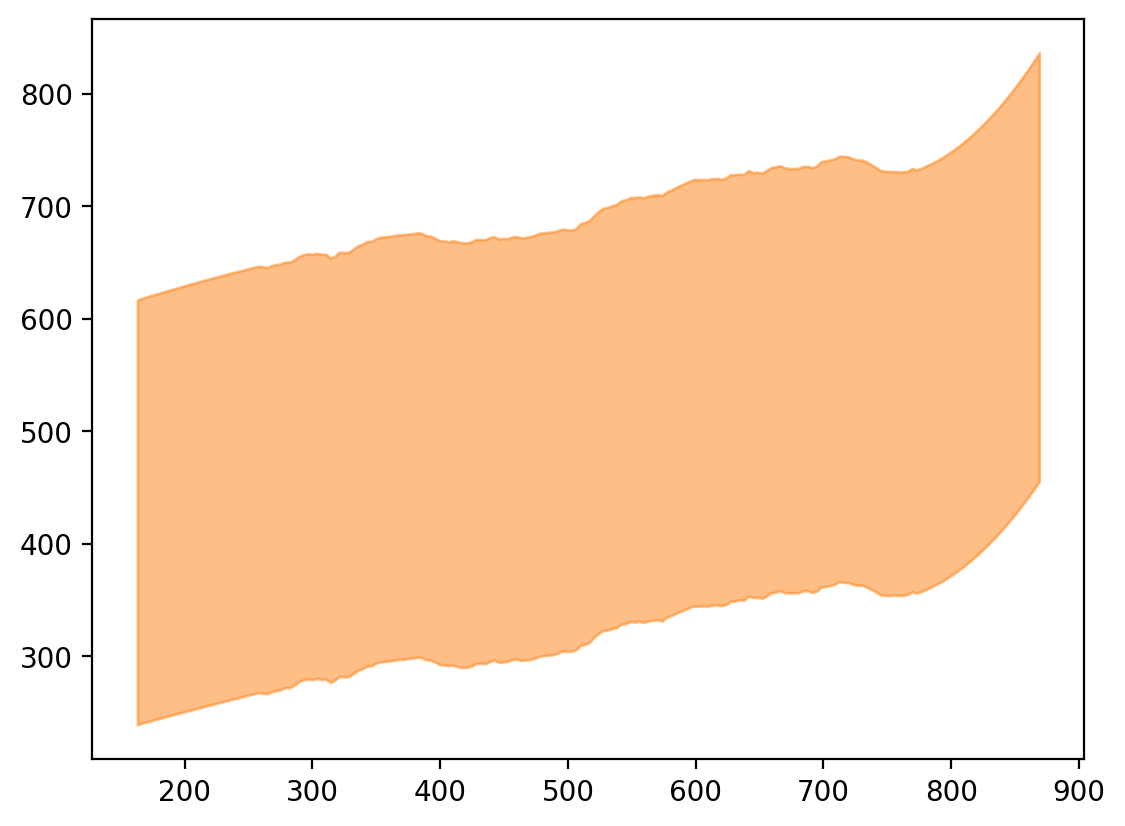

In [7]:
az.plot_hdi(PISA2018["PV1READ"],post_pred.posterior_predictive["PV1READ"], hdi_prob=0.95)
plt.show

In [8]:
%%time
#PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID)

with pm.Model() as model2:
    JOYREAD = pm.MutableData("JOYREAD",PISA2018["JOYREAD"])
    PISADIFF = pm.MutableData("PISADIFF", PISA2018["PISADIFF"])
    SCREADCOMP = pm.MutableData("SCREADCOMP", PISA2018["SCREADCOMP"])
    SCREADDIFF = pm.MutableData("SCREADDIFF", PISA2018["SCREADDIFF"])
    SchoolID = pm.MutableData("SchoolID", PISA2018["SchoolID"])

    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta_joyread = pm.Normal('beta_joyread', mu=np.mean(PISA2018["JOYREAD"]), sigma=np.std(PISA2018["JOYREAD"]))  # Coefficient for JOYREAD
    beta_pisadiff = pm.Normal('beta_pisadiff', mu=0, sigma=100)  # Coefficient for PISADIFF
    beta_screadcomp = pm.Normal('beta_screadcomp', mu=np.mean(PISA2018["SCREADCOMP"]), sigma=10)  # Coefficient for SCREADCOMP
    beta_screaddiff = pm.Normal('beta_screaddiff', mu=np.mean(PISA2018["SCREADDIFF"]), sigma=np.std(PISA2018["SCREADDIFF"]))  # Coefficient for SCREADDIFF

    sigma_school = pm.HalfNormal('sigma_school', sigma=100)
    intercept_school = pm.Normal('intercept_school', mu=0, sigma=sigma_school, shape=len(PISA2018["SchoolID"].unique()))

    PV1READ_mu = alpha + beta_joyread * JOYREAD + beta_pisadiff * PISADIFF + beta_screadcomp * SCREADCOMP\
        + beta_screaddiff * SCREADDIFF  + intercept_school[SchoolID]
    PV1READ_sigma = pm.HalfNormal('PV1READ_sigma', sigma=10)
    
    PV1READ = pm.Normal('PV1READ', mu=PV1READ_mu, sigma=PV1READ_sigma, observed=PISA2018['PV1READ'])
    
with model2:
    trace2 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, progressbar=False)

with model2:
    post_pred = pm.sample_posterior_predictive(trace2, random_seed=RANDOM_SEED, progressbar=False)
pred = post_pred.posterior_predictive["PV1READ"].mean(dim=["chain", "draw"])

print(f'The RMSE for model 2 - PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID) is: {sqrt(mean_squared_error(PISA2018["PV1READ"], pred))}')

The RMSE for model 2 - PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID) is: 86.03420433753293
CPU times: total: 13.4 s
Wall time: 1min 13s


<function matplotlib.pyplot.show(close=None, block=None)>

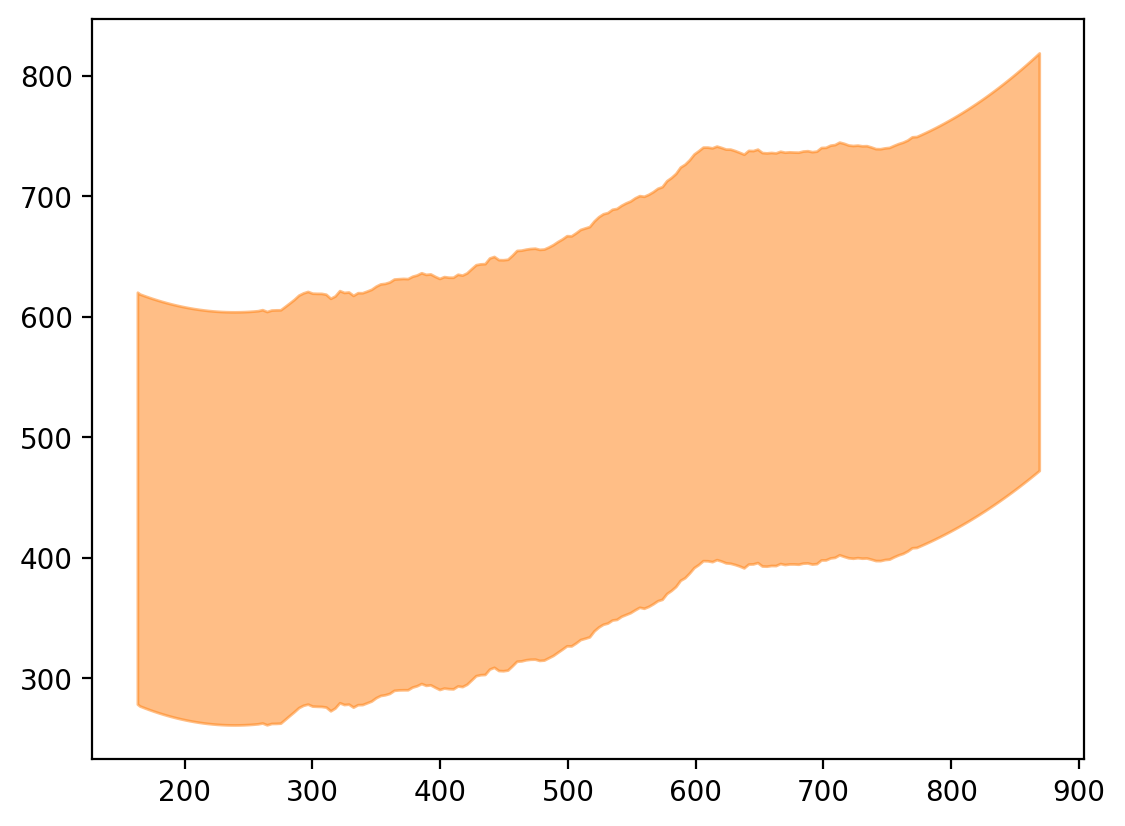

In [9]:
az.plot_hdi(PISA2018["PV1READ"],post_pred.posterior_predictive["PV1READ"], hdi_prob=0.95)
plt.show

In [10]:
%%time
#PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID) 

with pm.Model() as model3:
    METASUM = pm.MutableData("METASUM",PISA2018["METASUM"])
    GFOFAIL = pm.MutableData("GFOFAIL", PISA2018["GFOFAIL"])
    MASTGOAL = pm.MutableData("MASTGOAL", PISA2018["MASTGOAL"])
    SWBP = pm.MutableData("SWBP", PISA2018["SWBP"])
    WORKMAST = pm.MutableData("WORKMAST", PISA2018["WORKMAST"])
    ADAPTIVITY = pm.MutableData("ADAPTIVITY", PISA2018["ADAPTIVITY"])
    COMPETE = pm.MutableData("COMPETE", PISA2018["COMPETE"])
    SchoolID = pm.MutableData("SchoolID", PISA2018["SchoolID"])

    alpha = pm.Normal('alpha', mu=0, sigma=100)  # Intercept
    beta_metasum = pm.Normal('beta_metasum', mu=np.mean(PISA2018["METASUM"]), sigma=np.std(PISA2018["METASUM"]))  # Coefficient for METASUM
    beta_gfofail = pm.Normal('beta_gfofail', mu=0, sigma=100)  # Coefficient for GFOFAIL
    beta_mastgoal = pm.Normal('beta_mastgoal', mu=np.mean(PISA2018["MASTGOAL"]), sigma=10)  # Coefficient for MASTGOAL
    beta_swbp = pm.Normal('beta_swbp', mu=0, sigma=100)  # Coefficient for SWBP
    beta_workmast = pm.Normal('beta_workmast', mu=np.mean(PISA2018["WORKMAST"]), sigma=10)  # Coefficient for WORKMAST
    beta_adaptivity = pm.Normal('beta_adaptivity', mu=np.mean(PISA2018["ADAPTIVITY"]), sigma=100)  # Coefficient for ADAPTIVITY
    beta_compete = pm.Normal('beta_compete', mu=np.mean(PISA2018["COMPETE"]), sigma=np.std(PISA2018["COMPETE"]))  # Coefficient for COMPETE

    sigma_school = pm.HalfNormal('sigma_school', sigma=100)
    intercept_school = pm.Normal('intercept_school', mu=0, sigma=sigma_school, shape=len(PISA2018["SchoolID"].unique()))

    PV1READ_mu = alpha + beta_metasum * METASUM + beta_gfofail * GFOFAIL + beta_mastgoal * MASTGOAL\
        + beta_swbp * SWBP + beta_workmast * WORKMAST + beta_adaptivity * ADAPTIVITY\
        + beta_compete * COMPETE  + intercept_school[SchoolID]
    PV1READ_sigma = pm.HalfNormal('PV1READ_sigma', sigma=10)
    
    PV1READ = pm.Normal('PV1READ', mu=PV1READ_mu, sigma=PV1READ_sigma, observed=PISA2018['PV1READ'])
    

with model3:    
    trace3 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, progressbar = False)

with model3:
    post_pred = pm.sample_posterior_predictive(trace3, random_seed=RANDOM_SEED, progressbar = False)
pred = post_pred.posterior_predictive["PV1READ"].mean(dim=["chain", "draw"])

print(f'The RMSE for model 3 - PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID) is: {sqrt(mean_squared_error(PISA2018["PV1READ"], pred))}')

The RMSE for model 3 - PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID) is: 91.295815765343
CPU times: total: 15.6 s
Wall time: 1min 34s


<function matplotlib.pyplot.show(close=None, block=None)>

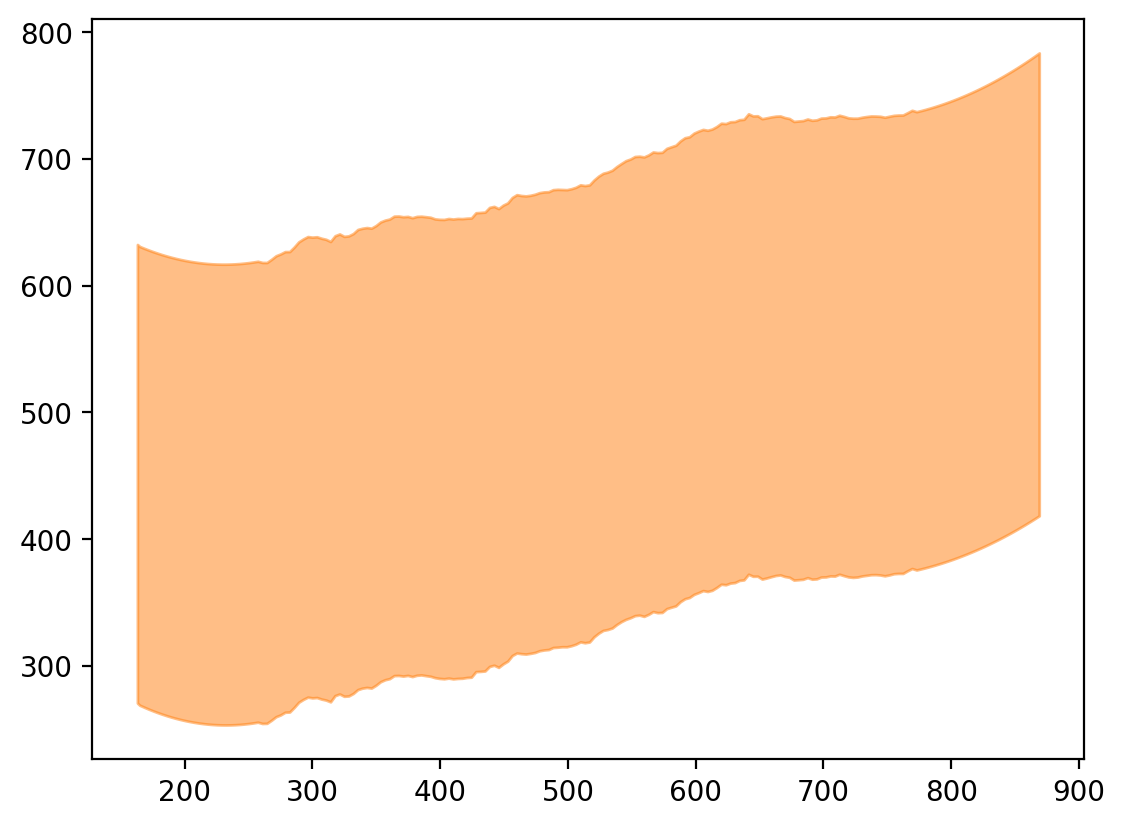

In [11]:
az.plot_hdi(PISA2018["PV1READ"],post_pred.posterior_predictive["PV1READ"], hdi_prob=0.95)
plt.show

In [12]:
%%time 
#PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID)

with pm.Model() as model4:
    PERFEED = pm.MutableData("PERFEED",PISA2018["PERFEED"])
    TEACHINT = pm.MutableData("TEACHINT", PISA2018["TEACHINT"])
    BELONG = pm.MutableData("BELONG", PISA2018["BELONG"])
    SchoolID = pm.MutableData("SchoolID", PISA2018["SchoolID"])

    
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta_perfeed = pm.Normal('beta_perfeed', mu = np.mean(PISA2018["PERFEED"]), sigma = np.std(PISA2018["PERFEED"]))  # Coefficient for PERFEED
    beta_teachint = pm.Normal('beta_teachint', mu=np.mean(PISA2018["TEACHINT"]), sigma = np.std(PISA2018["TEACHINT"]))  # Coefficient for TEACHINT
    beta_belong = pm.StudentT('beta_belong', nu = 1, mu=np.mean(PISA2018["BELONG"]), sigma=100)  # Coefficient for BELONG

    sigma_school = pm.HalfNormal('sigma_school', sigma=100)
    sigma_teachint = pm.HalfNormal('sigma_teachint', sigma=100)
    intercept_school = pm.Normal('intercept_school', mu=0, sigma=sigma_school, shape=len(PISA2018["SchoolID"].unique()))
    random_teachint = pm.Normal('random_teachint', mu=0, sigma=sigma_teachint, shape=len(PISA2018["SchoolID"].unique()))

    PV1READ_mu = alpha + beta_perfeed * PERFEED + beta_teachint * TEACHINT + beta_belong * BELONG\
        + random_teachint[SchoolID] * TEACHINT  + intercept_school[SchoolID]
    PV1READ_sigma = pm.HalfNormal('PV1READ_sigma', sigma=10)
    
    PV1READ = pm.Normal('PV1READ', mu=PV1READ_mu, sigma=PV1READ_sigma, observed=PISA2018['PV1READ'])
    

with model4:
    trace4 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, progressbar = False)

with model4:
    post_pred = pm.sample_posterior_predictive(trace4, random_seed=RANDOM_SEED, progressbar = False)
pred = post_pred.posterior_predictive["PV1READ"].mean(dim=["chain", "draw"])

print(f'The RMSE for model 4 - PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID) is: {sqrt(mean_squared_error(PISA2018["PV1READ"], pred))}')

The RMSE for model 4 - PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID) is: 94.72439565645705
CPU times: total: 17.2 s
Wall time: 1min 39s


<function matplotlib.pyplot.show(close=None, block=None)>

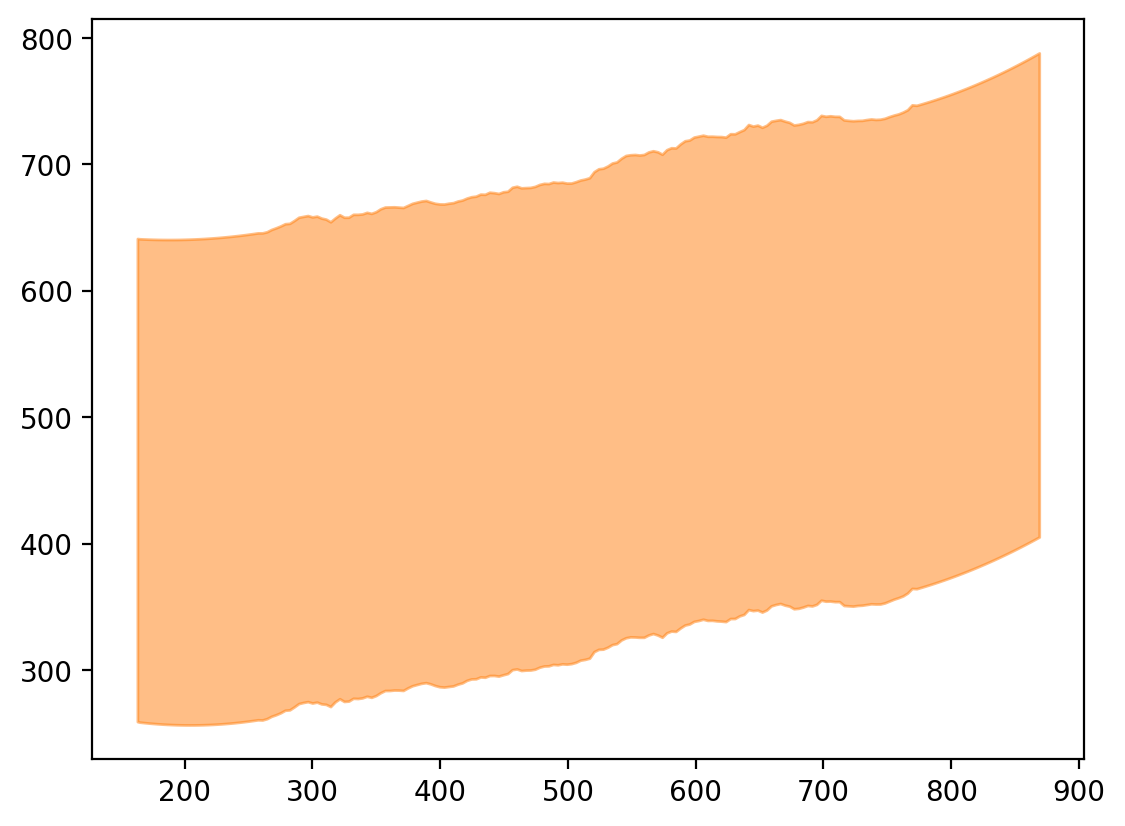

In [13]:
az.plot_hdi(PISA2018["PV1READ"],post_pred.posterior_predictive["PV1READ"], hdi_prob=0.95)
plt.show

In [14]:
# A wrapper class for the PYMC models to be compatible with the Taweret framework
class PYMCWrapper(BaseModel):
    def __init__(self, model, trace, pred_value):
        self.pymcmodel = model
        self.trace = trace
        self.pred_value = pred_value


    def evaluate(self, model_parameters):
        with self.pymcmodel:
            for entry in model_parameters:
                try:
                    pm.set_data(entry)
                except:
                    pass
            post_pred = pm.sample_posterior_predictive(self.trace, random_seed=RANDOM_SEED, progressbar = False)

        return np.array(post_pred.posterior_predictive[self.pred_value].mean(dim=["chain", "draw"]).data),\
                np.sqrt(np.array(post_pred.posterior_predictive[self.pred_value].var(dim=["chain", "draw"]))).flatten()

    
    def log_likelihood_elementwise(self,x_exp, y_exp, y_err, model_params):
        y = self.evaluate(model_params)[0]
        
        return np.exp(-(y - y_exp) **2 / (2 * y_err ** 2)) \
            / np.sqrt(2 * np.pi * y_err ** 2)
    
    def set_prior(self, prior_dict):
        pass


In [15]:
# Using the multivariate mixer to combine the four models in a gaussian form

# Defining a dictionary of the models
models = {
            "1": PYMCWrapper(model1, trace1, "PV1READ"),
            "2": PYMCWrapper(model2, trace2, "PV1READ"),
            "3": PYMCWrapper(model3, trace3, "PV1READ"),
            "4": PYMCWrapper(model4, trace4, "PV1READ")
}

# The multivariate model
multivariate_mixer = Multivariate(PISA2018, models)

# Gather predictions and calculate the RMSE score
draws, mean, intervals, std_dev = multivariate_mixer.predict(ci=95)

print(f'The RMSE score of the mixer: {((sqrt(mean_squared_error(PISA2018["PV1READ"], mean))))}')

The RMSE score of the mixer: 88.11346763610106
